In [1]:
import numpy             as np
import matplotlib.pyplot as plt

from skimage       import data
from skimage.color import rgb2grey

In [2]:
def metric(X,Y,e):
    x = np.abs( X.std() - Y.std() )
    return x<e

In [3]:
M, N = 6,5
D    = np.random.randn( M*N ).reshape( M,N )
C    = np.arange( D.size )   .reshape( M,N )

In [4]:
def aggl(X,X0,C,C0,e=.5):
    m = metric( X,X0, e)
    c = np.min( [C,C0] )
    return c, m

In [5]:
e = .3
for i in range(M-1):
    for j in range(N-1):
        m,c = aggl( D[i,j  ], 
                    D[i,j+1],
                    C[i,j  ], 
                    C[i,j+1], e)
        if m:
            C[i,j  ] = c
            C[i,j+1] = c
        
        m,c = aggl( D[i  ,j], 
                    D[i+1,j],
                    C[i,j  ], 
                    C[i+1,j], e)
        if m:
            C[i  ,j] = c
            C[i+1,j] = c

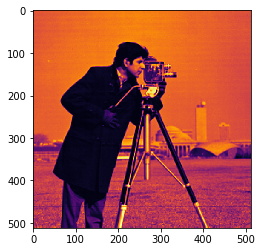

In [6]:
#im = rgb2grey( data.checkerboard() )
im = rgb2grey( data.camera() )
#im = rgb2grey( data.coins() )
plt.imshow(im,'inferno')

In [7]:
n     = 11
overl = 1.
step  = int( overl*n )

x,y = im.shape
x   = np.arange( 0,x-step,step)
y   = np.arange( 0,y-step,step)

x,y = np.meshgrid(x,y)

CPU times: user 587 ms, sys: 44.3 ms, total: 631 ms
Wall time: 579 ms


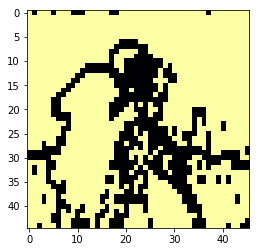

In [45]:
%%time
e = 2.
N = x.shape[1]
C = np.arange( x.size ); np.random.shuffle(C)
C = C.reshape( x.shape )
for n,(i,j) in enumerate( zip( x.ravel(),y.ravel() ) ):
    m,c = aggl( im[i:i+step,j  :j  +step], 
                im[i:i+step,j+1:j+1+step],
                C[n/N, n   %N],
                C[n/N,(n+1)%N], e)
    if m:
        C[n/N, n   %N] = c
        C[n/N,(n+1)%N] = c

    m,c = aggl( im[i  :i  +step,j:j+step], 
                im[i+1:i+1+step,j:j+step],
                C[n/N, n   %N],
                C[n/N,(n+1)%N], e)
    if m:
        C[n/N, n   %N] = c
        C[n/N,(n+1)%N] = c
    
plt.imshow(C[:,:-1].T ,cmap='inferno')

In [14]:
%%time
#H=[]
bins = np.linspace(0,256,20)
for n,(i,j) in enumerate( zip( x.ravel(),y.ravel() ) ):
    h = np.histogram( im[i:i+step,j:j+step].ravel(),bins=bins ) 
    #H.append( h[1] )

CPU times: user 217 ms, sys: 1.84 ms, total: 219 ms
Wall time: 221 ms


In [46]:
def Hist(x):
    h = np.histogram( x.ravel(),bins=bins )
    return h[1]

In [18]:
%%time
from multiprocessing import Pool
pool    = Pool(processes=20)
results = [ pool.apply_async(  Hist, args=(im[i:i+step,j:j+step],) ) for i,j in zip( x.ravel(),y.ravel() ) ]

output  = [p.get() for p in results]
output  = np.array(output)

CPU times: user 175 ms, sys: 84.1 ms, total: 259 ms
Wall time: 323 ms


In [52]:
%%time
from multiprocessing import Pool
pool    = Pool(processes=20)
results = [ pool.apply_async(  entropy, args=(im[i:i+step,j:j+step].flatten(),) ) for i,j in zip( x.ravel(),y.ravel() ) ]

output  = [p.get() for p in results]
output  = np.array(output)

CPU times: user 254 ms, sys: 211 ms, total: 466 ms
Wall time: 464 ms


In [53]:
output.shape

(2116,)

In [54]:
s      = x.shape
output = output.reshape( s[0],s[1] )
C      = np.arange( x.size ); np.random.shuffle(C)
C      = C.reshape( x.shape )

In [51]:
s      = x.shape
output = output.reshape( s[0],s[1],output.shape[-1] )
C      = np.arange( x.size ); np.random.shuffle(C)
C      = C.reshape( x.shape )

ValueError: cannot reshape array of size 2116 into shape (46,46,2116)

In [24]:
from scipy.stats import mannwhitneyu as utest

In [55]:
output.shape

(46, 46)

In [56]:
%%time
from multiprocessing import Pool
pool = Pool(processes=20)
R    = []
L    = []
for i in range(s[0]-1):
    for j in range(s[1]-1):
        R.append(
          pool.apply_async(  utest, args=(output[i,j],output[i,j+1],) )
        )
        L.append(
          pool.apply_async(  utest, args=(output[i,j],output[i+1,j],) )
        )
        

uwr  = [r.get() for r in R]
uwl  = [l.get() for l in L]
uwr  = np.array(uwr)
uwl  = np.array(uwl)

TypeError: len() of unsized object

In [40]:
%%time
from scipy.stats import entropy
from multiprocessing import Pool
pool = Pool(processes=20)
R    = []
L    = []
for i in range(s[0]-1):
    for j in range(s[1]-1):
        R.append(
          pool.apply_async(  entropy, args=(output[i,j],output[i,j+1],) )
        )
        L.append(
          pool.apply_async(  entropy, args=(output[i,j],output[i+1,j],) )
        )
        

uwr  = [r.get() for r in R]
uwl  = [l.get() for l in L]
uwr  = np.array(uwr)
uwl  = np.array(uwl)

CPU times: user 386 ms, sys: 171 ms, total: 556 ms
Wall time: 532 ms


In [41]:
#uwr = uwr.reshape( s[0]-1,s[1]-1,2 )
#uwl = uwl.reshape( s[0]-1,s[1]-1,2 )
#C.shape

uwr = uwr.reshape( s[0]-1,s[1]-1 )
uwl = uwl.reshape( s[0]-1,s[1]-1 )

In [62]:
C = np.arange( x.size ); np.random.shuffle(C)
C = C.reshape( x.shape )
e = 0.1
for i in range( uwr.shape[0] ):
    for j in range( uwr.shape[1] ):
        #if uwr[i,j] < e:
        if abs( output[i,j]-output[i,j+1] )<e:
            c        = np.min( [C[i,j],C[i,j+1]] )
            C[i,j  ] = c
            C[i,j+1] = c
        
        #if uwl[i,j] < e:
        if abs( output[i+1,j]-output[i,j] )<e:
            c        = np.min( [C[i,j],C[i+1,j]] )
            C[i  ,j] = c
            C[i+1,j] = c
C

array([[813, 925, 350, ..., 113, 113, 113],
       [813, 350, 350, ...,  27,  27,  27],
       [350, 350, 210, ...,   6,   6,   6],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0, 752]])

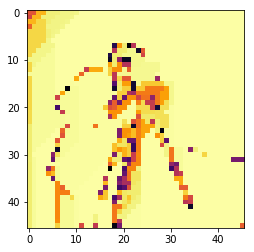

In [63]:
plt.imshow(-C.T,cmap='inferno')

In [64]:
set(C.ravel())

{0,
 2,
 3,
 5,
 6,
 8,
 9,
 11,
 13,
 14,
 15,
 18,
 23,
 24,
 25,
 26,
 27,
 28,
 35,
 38,
 39,
 42,
 51,
 53,
 58,
 65,
 66,
 68,
 74,
 77,
 79,
 85,
 93,
 95,
 97,
 102,
 104,
 105,
 109,
 110,
 113,
 118,
 123,
 129,
 138,
 142,
 144,
 158,
 168,
 171,
 184,
 189,
 202,
 203,
 208,
 210,
 214,
 216,
 221,
 230,
 232,
 236,
 237,
 243,
 252,
 262,
 269,
 283,
 291,
 301,
 312,
 328,
 338,
 350,
 352,
 353,
 356,
 365,
 393,
 394,
 395,
 406,
 410,
 414,
 418,
 419,
 436,
 442,
 443,
 461,
 472,
 497,
 503,
 504,
 505,
 512,
 521,
 526,
 547,
 551,
 562,
 582,
 595,
 599,
 607,
 614,
 621,
 629,
 637,
 643,
 645,
 646,
 647,
 652,
 653,
 710,
 722,
 727,
 728,
 729,
 750,
 752,
 756,
 776,
 783,
 787,
 805,
 811,
 813,
 833,
 835,
 841,
 848,
 880,
 881,
 887,
 898,
 917,
 918,
 925,
 940,
 956,
 968,
 975,
 985,
 987,
 994,
 995,
 1019,
 1020,
 1024,
 1040,
 1057,
 1058,
 1059,
 1071,
 1081,
 1087,
 1091,
 1093,
 1136,
 1137,
 1139,
 1145,
 1177,
 1206,
 1217,
 1254,
 1264,
 1266,


In [60]:
C[ C>17 ] = 17

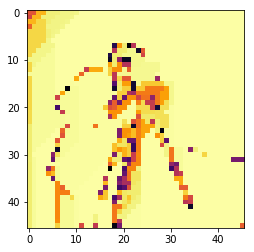

In [65]:
plt.imshow(-C.T,cmap='inferno')

In [159]:
C = np.arange( x.size ); np.random.shuffle(C)
C = C.reshape( x.shape )
e = 0.01
for i in range( uwr.shape[0] ):
    for j in range( uwr.shape[1] ):
        if uwr[i,j,1] < e:
            c        = np.min( [C[i,j],C[i,j+1]] )
            C[i,j  ] = c
            C[i,j+1] = c
        
        if uwl[i,j,1] < e:
            c        = np.min( [C[i,j],C[i+1,j]] )
            C[i  ,j] = c
            C[i+1,j] = c
C

IndexError: too many indices for array